In [ ]:
from google.colab import drive
import os
drive.mount('/gdrive')
os.chdir("/gdrive/My Drive/MLcontent/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


2.3.0
Index(['Total Solids_1', 'SS_1', 'BOD5_1', 'NH3_1', 'Org-N_1', 'P-TOT_1',
       'SO4_1', 'TKN_1', 'PRCP_NOOA_1', 'Total Solids_2', 'SS_2', 'BOD5_2',
       'NH3_2', 'Org-N_2', 'P-TOT_2', 'SO4_2', 'TKN_2', 'PRCP_NOOA_2',
       'Total Solids_3', 'SS_3', 'BOD5_3', 'NH3_3', 'Org-N_3', 'P-TOT_3',
       'SO4_3', 'TKN_3', 'PRCP_NOOA_3', 'Total Solids_4', 'SS_4', 'BOD5_4',
       'NH3_4', 'Org-N_4', 'P-TOT_4', 'SO4_4', 'TKN_4', 'PRCP_NOOA_4',
       'Total Solids_5', 'SS_5', 'BOD5_5', 'NH3_5', 'Org-N_5', 'P-TOT_5',
       'SO4_5', 'TKN_5', 'PRCP_NOOA_5', 'Total Solids_6', 'SS_6', 'BOD5_6',
       'NH3_6', 'Org-N_6', 'P-TOT_6', 'SO4_6', 'TKN_6', 'PRCP_NOOA_6',
       'Total Solids_7', 'SS_7', 'BOD5_7', 'NH3_7', 'Org-N_7', 'P-TOT_7',
       'SO4_7', 'TKN_7', 'PRCP_NOOA_7'],
      dtype='object')
Epoch 1/17
263/263 [==============================] - 2s 9ms/step - loss: 0.0443 - mae: 0.0443 - val_loss: 0.0310 - val_mae: 0.0310
Epoch 2/17
263/263 [==============================] - 2s 7ms/s

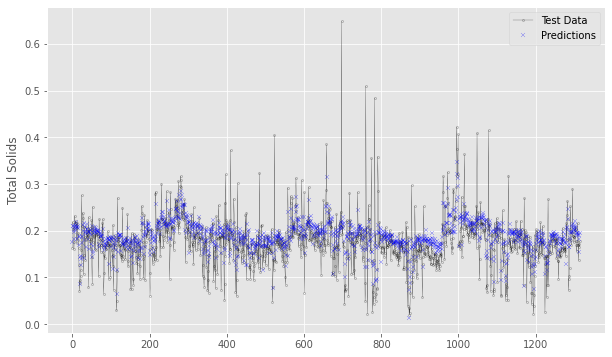

In [ ]:
from pandas import read_csv
from pandas import datetime
from pandas import to_numeric
from pandas import concat
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf

#tf.enable_v2_behavior()
from tensorflow.compat.v1.keras import backend as K
from keras.layers import SimpleRNN, Dense, LSTM, Bidirectional, GRU
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint

import os
import random as rn
#from keras import backend as K

print(tf.__version__)

#Setting a seed for the computer's pseudorandom number generator. 
#This allows us to reproduce the results from our script:
n = 5
np.random.seed(100 * n)
rn.seed(10000 * n)

#Depending on the actual running environment, you may specify if using GPU, or only CPU.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#Tensorflow session configuration.
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

tf.compat.v1.set_random_seed(1000 * n)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

series = read_csv('Wastewater_Data.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
series = series.replace('^\s*$', np.nan, regex=True)
series = series.fillna(method='ffill')
series = series.apply(to_numeric)

#lag defines how many historical data are used to predict a specific wasterwater characteristic (e.g., BOD5)
lag = 7

#num_features defines how many historical wasterwater characteristics are used. We have 9 in total (i.e., TS, BOD5, NH3, etc.)
num_features = 9

from pandas import DataFrame
from sklearn import preprocessing
names = series.columns
x = series.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
series_normalized = DataFrame(x_scaled, columns=names)

#The following line of code will do the same normalization as the code above.
#series_normalized = (series - np.min(series))/(np.max(series)-np.min(series))

# table2lags() Shifts a dataFrame along its time axis (i.e., index) n steps 
# (moving down/up if step is a positive/negative number), determined by min_lag and max_lag, 
# and merge all shiffted dataframes into a single one and return, 
# without including the original DataFrame (the one shifted 0 step).
# "values" is a list, and each item in "values" is a shifted dataframe.
# Input: Table: a DataFrame; max_lag: the maximum shifting; min_lag: the minimum shifting; 
# In this module, no need to include the original dataframe or shift the dataframe up, and thus min_lag = 1 by default
# separator: used to concatenate the step value (e.g., 1, 2, 3) to the original column label. E.g., SO4_1, SO4_2, etc.
# Output: a dataframe

def table2lags(table, max_lag, min_lag=1, separator='_'):
    values = []
    for i in range(min_lag, max_lag + 1):
        #append shiffted dataframe into the list (i.e., values)
        values.append(table.shift(i).copy()) 
        #replace the last item or dataframe's columns by column_n; n is the shift step  
        values[-1].columns = [c + separator + str(i) for c in table.columns] 
    #pandas.concat is used to merge all dataframes (as items in values) into a single dataframe
    return concat(values, axis=1) 

#prepare all historical (e.g., one day ago, two day ago,...) data into one dataframe. 
#For all missing data, replaced by its closest future values
X = table2lags(series_normalized, lag)
X = X.fillna(method='bfill')
print(X.columns)

#targetList = ["Total Solids",	"SS", 	"BOD5",	"NH3",	"Org-N",	"P-TOT",	"SO4",	"TKN",	"PRCP_NOOA"]
targetList = ["Total Solids"]
for name in targetList:
    targetDF = series_normalized[name].to_frame()
    #print(X_test)
    size = int(len(X) * 0.8) #split the data into training set (80%) and validation set
    train = X[0:size]
    train_target = targetDF[0:size]
    test = X[size:len(X)]
    test_target = targetDF[size:len(X)]

    X_train = train.values.reshape(-1, lag, num_features).astype('float32')
    y_train = train_target.values.astype('float32')

    X_test = test.values.reshape(-1, lag, num_features).astype('float32')
    y_test = test_target.values.astype('float32')
    
    hidden = 64
    batch_size = 20
    epochs = 17

    #we'll import the Sequential model type from Keras. 
    #This is simply a linear stack of neural network layers, and it's perfect for the type of feed-forward CNN and RNN
    model = Sequential()
    model.add(Bidirectional(LSTM(hidden), input_shape=(lag, num_features)))
    model.add(Dense(1))

    model.compile(optimizer='adam',
                loss='mae',
                metrics=['mae'])
 

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test,y_test))

    y_predict = model.predict(X_test)
    plt.style.use("ggplot")

    plt.figure(figsize=(10, 6))
    plt.plot(y_test, color='black', linewidth=.2, marker='o', markersize=2,
                markeredgecolor='black', markeredgewidth=0.2, fillstyle='none')
    plt.plot(y_predict, color='blue', linewidth=4, linestyle=' ', marker='x', markersize=4,
                markeredgecolor='blue', markeredgewidth=.2, fillstyle='none')
    plt.legend(('Test Data', 'Predictions'))
    #plt.savefig(name+".png", dpi = 600)
    plt.ylabel(name)

    plt.show()
